# Death by Asteroid

### Bennett Taylor and Olivia Seitelman

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import math as math

import numpy as np
import matplotlib.pyplot as ply
import scipy, pylab

## Question

If an asteroid is passing Earth at a set distance, at what velocity would it enter Earth's orbit or collide with Earth?

This question is important to everyone on Earth, as asteroids pose a threat to human life and their impact can be predicted and prevented.

## Model

We chose to model an asteroid that is approaching the Earth at a varying velocity and will pass tangentially at a set distance. The asteroid starts at `3e8 * m`, which is almost the distance to the moon, and the only force acting on the asteroid is Earth's gravity. Our asteroid is the size of the one that killed the dinosaurs, with a radius of `5000 *m` and a mass of about `6.1e15 * kg`.

To model the asteroid, we created universal gravitation and slope functions to determine the force on the asteroid, and then used the ode solver. We used a sweepseries to sweep velocity values and graphed their different orbits.

### Schematic
!["Model Schematic"](schematic.png)

Our model follows a fairly straigh forward phenomenon:the gravitational attraction of the Earth on a passing asteroid.

### Differential Equations
\begin{align}
\frac{dv}{dt} = G \times \frac{m_1 \times m_2}{r^2} \\
\frac{dy}{dt} = v
\end{align}

We used the universal gravitation equation, converting force into the change in velocity over time. For the purposes of using run_ode_solver, we then turned this into a derivative of position, as to have it running a first order differential equation.

### Python

Having sketched a schematic and determined our equations, we then went to work writing the model in Python.

In [2]:
#the units we will be using throughout
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
AU = UNITS.astronomical_unit
N = UNITS.newton

<Unit('newton')>

First, we will define our state. The asteroid starts at `(300000 * m, 300000 * m)` with an initial velocity of `-1000 * m/s` in the y direction.

In [3]:
#asteroid is starting approximately "r" away in the x and y distance
px_0 = 300000 * m
py_0 = 300000 * m
vx_0 = 0 * m/s
vy_0 = -1000 * m/ s
init = State(px=px_0,
             py=py_0,
             vx=vx_0,
             vy=vy_0)

,values
px,300000 meter
py,300000 meter
vx,0.0 meter / second
vy,-1000.0 meter / second


Next, we create our system using a make system function from the state variables we have previously defined.  We will define the universal gravitation constant, the masses of the bodies, the initial and final times, and the combined radii of the earth and asteroid to help define the event function.

In [4]:
def make_system(px_0, py_0, vx_0, vy_0):
    
    init = State(px=px_0 * m,
         py=py_0 * m,
         vx=vx_0 * m/s,
         vy=vy_0 * m/s)
    
        #universal gravitation value
    G = 6.67408e-11*N/(kg**2 * m**2)
    
         #mass of asteroid that killed dinosaurs
    m1 = 6.1e15* kg
    
        #earth mass
    m2 = 5.972324e24* kg
    
        #intial and final time (0s and 1 year in seconds)
    t_0 = 0 * s
    t_end = 315360000 * s
    
        #radius of earth plus radius of asteroid that killed the dinosaurs
    r_final = 6376000 * m

    print(init)
    return System(init=init, G=G, m1=m1, m2=m2, t_0=t_0, t_end=t_end, r_final=r_final)

We then made the system with our chosen values of our state variables.

In [5]:
    #asteroid is starting approximately one moon's distance away in the
    #x and y distance (selected for feasability, asteroids would rarely pass closer)
system = make_system(300000, 300000, 0, -1000)

px              300000 meter
py              300000 meter
vx        0.0 meter / second
vy    -1000.0 meter / second
dtype: object


,values
init,px 300000 meter py 3...
G,6.67408e-11 newton / kilogram ** 2 / meter ** 2
m1,6100000000000000.0 kilogram
m2,5.972324e+24 kilogram
t_0,0 second
t_end,315360000 second
r_final,6376000 meter


We define the universal gravitation function to determine the force on the asteroid caused by the Earth.

In [6]:
def universal_gravitation(state, system):
    #position and velocity in x and y directions
    px, py, vx, vy = state
    unpack(system)
    
    #divide magnitude of position by vector  of position to find direction
    position = Vector(px, py)
    P = sqrt(px**2/m**2 + py**2/m**2)
    #Calculate magnitude of gravitational force
    F_magnitude = G * m1 * m2/ ((P)**2)
    
    P_direction = position/P
    
    #give direction to force magnitude, make it a force vector
    F = P_direction * (-1) * F_magnitude * m

    
    return F

In [7]:
universal_gravitation(init, system)

<Quantity([-9.55162141e+18 -9.55162141e+18], 'newton')>

We create an event function to stop the ode solver just before the asteroid hits the earth, meaning that the asteroid is at `r_final`, the sum of the radii of the earth and the asteroid. 

In [8]:
#this did not end up functioning as we had desired, but is left in incase of use in future model
def event_func(state, t, system):

    px, py, vx, vy = state
    
    #find absolute value of position relative to earth
    P = abs(sqrt(px**2 + py**2))
    
    #return zero when distance equals distance between the center points of the asteroid and the earth
    #(when they are touching)
    return P - abs(system.r_final - 1)

In [9]:
universal_gravitation(init, system)

<Quantity([-9.55162141e+18 -9.55162141e+18], 'newton')>

The slope function returns derivatives that can be processed by the ode solver.

In [10]:
def slope_func(state, t, system):
    px, py, vx, vy = state
    unpack(system)
    
    #combind x and y components to make one position value
    position = Vector(px, py)
    
    #set force using universal ravitation function
    F = universal_gravitation(state, system)
    
    #seperate force into x and y components
    Fx = F.x
    Fy = F.y
    
    #set chain of differentials, so acceleration (Force divided by mass) is equal to dv/dt
    #and v is equal to dpdt, each in x and y components
    dpxdt = vx
    
    dpydt = vy
    
    dvxdt = Fx/m1
    
    dvydt = Fy/m1
    
    
    return dpxdt, dpydt, dvxdt, dvydt

Calling the slope function should return the x and y velocities we set and the force in the x and y directions, and checking this proves it true

In [11]:
#test slope func
slope_func(init, 0, system)

(<Quantity(0.0, 'meter / second')>,
 <Quantity(-1000.0, 'meter / second')>,
 <Quantity(-1565.839575767627, 'newton / kilogram')>,
 <Quantity(-1565.839575767627, 'newton / kilogram')>)

In [12]:
#test gravity value
grav = universal_gravitation(init, system)

<Quantity([-9.55162141e+18 -9.55162141e+18], 'newton')>

The ode solver will return values for x position, y position, x velocity, and y velocity as the asteroid moves through space. X position and y position will then be divided by 1e9 such that they are expresses in millions of kilometers. 

In [13]:
#run ode, with results scaled down to millions
results, details = run_ode_solver(system, slope_func, vectorized = True, events = event_func)
results.px/=1e6
results.py/=1e6

In [14]:
#note that success is listed as false
#the ode solver would not allow the asteroid to hit the earth, no matter how we changed the event function or equations
#we later impliment an if then statement into the return to work around this
print(details)
results.tail()

sol                                                      None
t_events                                                 [[]]
nfev                                                    23444
njev                                                        0
nlu                                                         0
status                                                     -1
message     Required step size is less than spacing betwee...
success                                                 False
dtype: object


,px,py,vx,vy
17.664187,-8.135517e-11,2.326817e-11,6.475701e+08,2.092805e+09
17.664187,-2.202471e-11,8.062377e-11,2.128075e+09,5.627940e+08
17.664187,5.772468e-11,6.016299e-11,1.572694e+09,-1.524570e+09
17.664187,8.081795e-11,-1.841503e-11,-5.172692e+08,-2.125779e+09
17.664187,2.401861e-11,-7.774800e-11,-2.129400e+09,-5.942638e+08


Plotting x position and y position separately against time produces two nearly identical lines that shown the asteroid getting closer and closer to the earth and then orbiting it in an off center ellipse until it inevitably collides. 

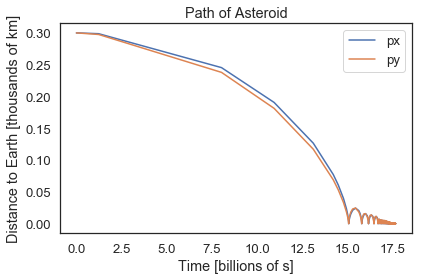

In [15]:
#plot x and y relative to time
results.px.plot()
results.py.plot()
decorate(ylabel='Distance to Earth [thousands of km]',
        xlabel='Time [billions of s]',
         title='Path of Asteroid')

We can also plot the asteroid on x and y axes to see its motion towards the Earth.

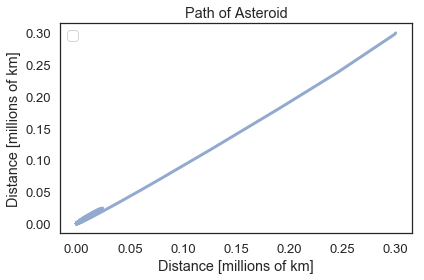

In [16]:
#plot x vs y to find full position
plot(results.px,results.py)
decorate(xlabel='Distance [millions of km]', 
         ylabel='Distance [millions of km]',
         title='Path of Asteroid')

We can limit the axes to zoom in on its impact with the Earth, which is at the center of the ellipses.

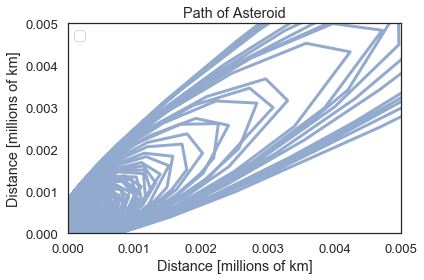

In [17]:
axes = plt.gca()
axes.set_xlim([0, 0.005])
axes.set_ylim([0, 0.005])
plot(results.px,results.py)
decorate(xlabel='Distance [millions of km]', 
         ylabel='Distance [millions of km]',
         title='Path of Asteroid')

The event function cannot accurately determine if the asteroid hits the Earth, as the distance between the two gets so small but the event function will never let them collide. Instead of the event function, we can use a function to determine if the last value of the results for x and y are close enough to the Earth such that the asteroid will be guaranteed to hit. 

In [18]:
def collision_result(results):
    #store and print final x and y position of asteroid relative to earth
    colvalx = get_last_value(results.px)
    colvaly = get_last_value(results.py)
    print('Final X Value =', colvalx)
    print('Final Y Value =', colvaly)

    #if the asteroid is within 1 meter of the Earth after a year of orbit, it is assumed that it will hit the earth
    if -1 < colvalx and colvaly < 1:
        print ('Kaboom! The asteroid hit!')
    else:
        print ('We live to love another day!')

In [19]:
#test
collision_result(results)

Final X Value = 2.401860681452048e-11
Final Y Value = -7.774799575110359e-11
Kaboom! The asteroid hit!


## Results

Sweeping the velocity can show what happens to the asteroid at varying speeds. In this first sweeep, all 5 of the swept speeds result in the asteroid colliding with the Earth. The velocities vary from `1000 * m/s` and `10000 * m/s` in this sweep. We vary the linspace to narrow into the correct velocity or small range in which the asteroid will go into orbit.

px              300000 meter
py              300000 meter
vx        0.0 meter / second
vy    -1000.0 meter / second
dtype: object
Final X Value = 2.401860681452048e-05
Final Y Value = -7.774799575110359e-05
Kaboom! The asteroid hit!
px              300000 meter
py              300000 meter
vx        0.0 meter / second
vy    -3250.0 meter / second
dtype: object
Final X Value = -0.00019528327106418505
Final Y Value = -5.689207691431667e-05
Kaboom! The asteroid hit!
px              300000 meter
py              300000 meter
vx        0.0 meter / second
vy    -5500.0 meter / second
dtype: object
Final X Value = -0.00022003510963148853
Final Y Value = 0.0002437331262958202
Kaboom! The asteroid hit!
px              300000 meter
py              300000 meter
vx        0.0 meter / second
vy    -7750.0 meter / second
dtype: object
Final X Value = -0.00042688559468384346
Final Y Value = 0.00029666007725250536
Kaboom! The asteroid hit!
px               300000 meter
py               300000 meter
vx 

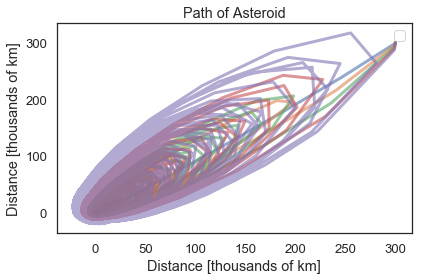

In [20]:
    vel_array = linspace(1000, 10000, 5)  
    
    #sweep starting velocities between 1000 and 10000 in the y direction
for sweep_vel in vel_array:
        system = make_system(300000, 300000, 0, -1*sweep_vel)
        results, details = run_ode_solver(system, slope_func, vectorized = True, events = event_func)
        collision_result(results)
        
        #scale results to thousands of km and plot
        results.px/=1e3
        results.py/=1e3
        plot(results.px,results.py)
        decorate(xlabel='Distance [thousands of km]', 
         ylabel='Distance [thousands of km]',
         title='Path of Asteroid')

The second sweep takes velocities between 10,000 m/s and 100,000 m/s. The asteroid hits the Earth at 10,000 m/s and 32,500 m/s, but not at 55,000 m/s, 77,500 m/s, or 100,000 m/s.

px               300000 meter
py               300000 meter
vx         0.0 meter / second
vy    -10000.0 meter / second
dtype: object
Final X Value = 4.212912287762479e-10
Final Y Value = 2.9198178720398924e-10
Kaboom! The asteroid hit!
px               300000 meter
py               300000 meter
vx         0.0 meter / second
vy    -32500.0 meter / second
dtype: object
Final X Value = -2.067160076302617e-09
Final Y Value = 2.242539025830517e-10
Kaboom! The asteroid hit!
px               300000 meter
py               300000 meter
vx         0.0 meter / second
vy    -55000.0 meter / second
dtype: object
Final X Value = -5.245427631310573
Final Y Value = -3.6247554693640422
We live to love another day!
px               300000 meter
py               300000 meter
vx         0.0 meter / second
vy    -77500.0 meter / second
dtype: object
Final X Value = -2.409022702405719
Final Y Value = -5.903386559195902
We live to love another day!
px                300000 meter
py                300000 met

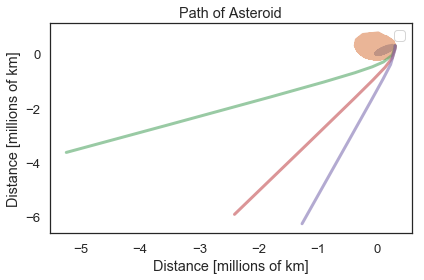

In [21]:
    vel_array2 = linspace(10000, 100000, 5)  
    
    #range of sweep altered to 10000 to 100000
for sweep_vel in vel_array2:
        system = make_system(300000, 300000, 0, -1*sweep_vel)
        results, details = run_ode_solver(system, slope_func, vectorized = True, events = event_func)
        
        #results scaled to millions of km, then plotted
        results.px/=1e6
        results.py/=1e6
        collision_result(results)
        plot(results.px,results.py)
        decorate(xlabel='Distance [millions of km]', 
         ylabel='Distance [millions of km]',
         title='Path of Asteroid')

The next sweep takes a much narrower range to determine the exact point at which the asteroid narrowly misses colliding with the Earth. That velocity is shown to be somewhere in between 42098.3 m/s and 42106.0 m/s.

px               300000 meter
py               300000 meter
vx         0.0 meter / second
vy    -42083.0 meter / second
dtype: object
Final X Value = -0.005971722393688606
Final Y Value = 0.006109688285641839
Kaboom! The asteroid hit!
px                          300000 meter
py                          300000 meter
vx                    0.0 meter / second
vy    -42090.666666666664 meter / second
dtype: object
Final X Value = 0.00587532360500044
Final Y Value = -0.012262102623406948
Kaboom! The asteroid hit!
px                          300000 meter
py                          300000 meter
vx                    0.0 meter / second
vy    -42098.333333333336 meter / second
dtype: object
Final X Value = 0.011949571677247443
Final Y Value = 0.007136124368947902
Kaboom! The asteroid hit!
px               300000 meter
py               300000 meter
vx         0.0 meter / second
vy    -42106.0 meter / second
dtype: object
Final X Value = -4566115.382494392
Final Y Value = 4450163.318547882
We liv

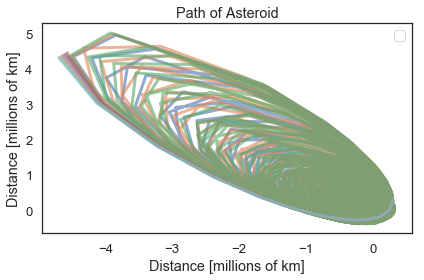

In [24]:
    vel_array4 = linspace(42083.0, 42152, 10)  
    
    #range narrowed from 42083 to 42152
for sweep_vel in vel_array4:
        system = make_system(300000, 300000, 0, -1*sweep_vel)
        results, details = run_ode_solver(system, slope_func, vectorized = True, events = event_func)
        collision_result(results)
        
        #results scaled to millions of km, then plotted
        results.px/=1e6
        results.py/=1e6
        plot(results.px,results.py)
        decorate(xlabel='Distance [millions of km]', 
         ylabel='Distance [millions of km]',
         title='Path of Asteroid')

Narrowing even further, the asteroid collides when it it travelling between 42099.0 m/s and 42100.0 m/s.

px               300000 meter
py               300000 meter
vx         0.0 meter / second
vy    -42098.0 meter / second
dtype: object
Final X Value = -0.010037090056138108
Final Y Value = -0.009028403359159429
Kaboom! The asteroid hit!
px               300000 meter
py               300000 meter
vx         0.0 meter / second
vy    -42099.0 meter / second
dtype: object
Final X Value = -0.005490367335749029
Final Y Value = 0.012047648068709477
Kaboom! The asteroid hit!
px               300000 meter
py               300000 meter
vx         0.0 meter / second
vy    -42100.0 meter / second
dtype: object
Final X Value = -4544786.852473755
Final Y Value = 4471943.169762189
We live to love another day!
px               300000 meter
py               300000 meter
vx         0.0 meter / second
vy    -42101.0 meter / second
dtype: object
Final X Value = -4548444.578457363
Final Y Value = 4468222.819500256
We live to love another day!
px               300000 meter
py               300000 meter
vx   

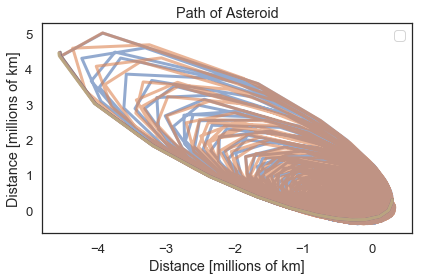

In [25]:
    vel_array5 = linspace(42098.0, 42106, 9)  
    
    #resuts narrowed from 42098 to 42106, all integers tested
for sweep_vel in vel_array5:
        system = make_system(300000, 300000, 0, -1*sweep_vel)
        results, details = run_ode_solver(system, slope_func, vectorized = True, events = event_func)
        collision_result(results)
        
        #results scaled to millions of km, then plotted
        results.px/=1e6
        results.py/=1e6
        plot(results.px,results.py)
        decorate(xlabel='Distance [millions of km]', 
         ylabel='Distance [millions of km]',
         title='Path of Asteroid')

## Interpretation

The asteroid collides with the Earth at velocities of about 42099.0 m/s and below. It slowly converges on the Earth until it eventually hits. Through a sweep of each indicidual starting velocity, we were able to determine to the integer of the velocity at what point an asteroid would be pulled in, given a set starting point.
At a speed somewhere between 42099.0 m/s and 42100.0 m/s, our model predicts that the asteroid goes into orbit.
At velocity of about 42100.0 m/s and above, the asteroid is travelling fast enough to escape Earth's gravity and does not collide.

Our model did work as expected, although we initially intended to only use the event function and then let the Earth revolve around the sun but we had to redesign our model using an if then statement and a logical assumption (that an asteroid 1 m away from the surface of the earth will collide with it) after the event function did not work. 

Our model also has further application, as starting position and velocity can both be altered, with a readable and clear output of both visual and verbal confirmation. To take the model further, we would have introduced the sun and its gravity, placing the earth into orbit to make the model fully accurate to our star system, but the current iteration is sufficient for calculating rough velocities for impact.